In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext line_profiler

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
sess_config = tf.ConfigProto()

import sys
import os

COCO_DATA = 'data/coco/'
MASK_RCNN_MODEL_PATH = 'lib/Mask_RCNN/'

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config
   
import time
import datetime
import random
import numpy as np
import skimage.io
import imgaug
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")



Using TensorFlow backend.


### Dataset

In [2]:
index = 1
one_shot_classes = np.array([4*i + index for i in range(20)])
train_classes = np.array(range(1,81))[np.array([i not in one_shot_classes for i in range(1,81)])]

In [3]:
# Load COCO/val dataset
coco_val = siamese_utils.IndexedCocoDataset()
coco_object = coco_val.load_coco(COCO_DATA, subset="val", year="2017", return_coco=True)
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = one_shot_classes

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


### Model

In [4]:
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100
    

class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1

In [5]:
model_size = 'large'
#model_size = 'small'

In [6]:
if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     1024
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_loss': 0.1, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_los

In [7]:
# Provide training schedule of the model
# When evaluationg intermediate steps the tranining schedule must be provided
train_schedule = OrderedDict()
if model_size == 'small':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[120] = {"learning_rate": config.LEARNING_RATE, "layers": "4+"}
    train_schedule[160] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}
elif model_size == 'large':
    train_schedule[1] = {"learning_rate": config.LEARNING_RATE, "layers": "heads"}
    train_schedule[240] = {"learning_rate": config.LEARNING_RATE, "layers": "all"}
    train_schedule[320] = {"learning_rate": config.LEARNING_RATE/10, "layers": "all"}


In [8]:
#Select checkpoint
if model_size == 'small':
    checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'
elif model_size == 'large':
    checkpoint = 'checkpoints/large_siamese_mrcnn_coco_full_0320.h5'

### Visualization

In [9]:
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint, training_schedule=train_schedule)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
loading checkpoints/large_siamese_mrcnn_coco_full_0320.h5 ...
starting from epoch 320


In [ ]:
if model_size == 'small':
    small_yaml = model.keras_model.to_yaml()
    with open("SmallModel.yaml", "w") as yaml_file:
        yaml_file.write(small_yaml)
elif model_size == 'large':
    large_yaml = model.keras_model.to_yaml()
    with open ("LargeModel.yaml", "w") as yaml_file:
        yaml_file.write(large_yaml)

image_id 4357
Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 1, 192, 192, 3)   min:    0.00000  max:  233.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
molded_targets           shape: (1, 1, 192, 192, 3)   min:    0.00000  max:  233.00000  uint8
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


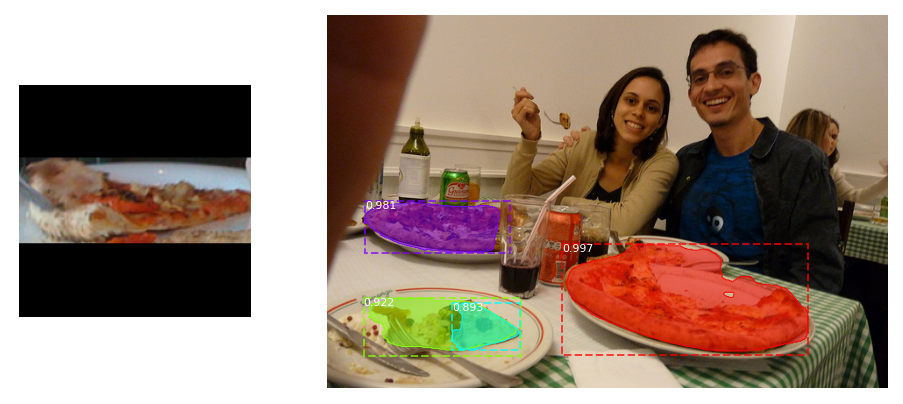

In [10]:
# Select category
category = 54
image_id = np.random.choice(coco_val.category_image_index[category])   
# Load target
target = siamese_utils.get_one_target(category, coco_val, config)
# Load image
image = coco_val.load_image(image_id)
print("image_id", image_id)


# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])

In [11]:
from fastapi import FastAPI

In [12]:
app = FastAPI()

In [14]:
@app.get('/healthcheck', status_code=200)
async def healthcheck():
    return 'Good to go'

In [17]:
def load_model(yaml_file_path, checkpoint):
    with open(yaml_file_path, "r") as yaml_file:
        loaded_model_yaml = yaml_file.read()
    loaded_model = model.keras_model.model_from_yaml(loaded_model_yaml)
    loaded_model.keras_model.get_weights(checkpoint)
    return loaded_model

loaded_model = load_model('models/large_siamese_mrcnn_coco_full_0320.yaml', checkpoint=checkpoint)

FileNotFoundError: [Errno 2] No such file or directory: '/models/large_siamese_mrcnn_coco_full_0320.yaml'